# Day 2 
[![Author - DanRamirez](https://img.shields.io/badge/Author-DanRamirez-2ea44f?style=for-the-badge)](https://github.com/Dandata0101)
![Python - Version](https://img.shields.io/badge/PYTHON-3.11-red?style=for-the-badge&logo=python&logoColor=white)
[![Project Repo](https://img.shields.io/badge/Our_Project_Repo-Visit-blue?style=for-the-badge&logo=github&logoColor=white)](https://github.com/Dandata0101/mbs-fraud-detection)

I used LightGBM to explain Top impacting features to the **TARGET** variable for the training and Test Application Files. Before producing any analysis, I converted csv files in Parquet files to flatten and reduce the size of files by more than half.

#  flattening file sizes

In [13]:
# select at least 3 variables for this analysis

import os
import sys
from scripts.csvtopaquet import csv_to_parquet_single_file
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

current_directory = os.getcwd()
csv1_file_path = os.path.join(current_directory, '01-data', 'FD_02_apl_test.csv')
csv2_file_path = os.path.join(current_directory, '01-data', 'FD_02_apl_train.csv')

output_file_path1 = os.path.join(current_directory, '01-data', 'FD_02_apl_test.parquet')
output_file_path2 = os.path.join(current_directory, '01-data', 'FD_02_apl_train.parquet')

csv_to_parquet_single_file(csv_file_path=csv1_file_path, output_file_path=output_file_path1, chunksize=100000, sample_rows=None, drop_columns=None)
csv_to_parquet_single_file(csv_file_path=csv2_file_path, output_file_path=output_file_path2, chunksize=100000, sample_rows=None, drop_columns=None)

Row count before sampling: 48744
Row count after sampling: 48744
Conversion completed. The data has been saved to '/Users/danramirez/mbs-fraud-detection/01-data/FD_02_apl_test.parquet'.
Row count before sampling: 307511
Row count after sampling: 307511
Conversion completed. The data has been saved to '/Users/danramirez/mbs-fraud-detection/01-data/FD_02_apl_train.parquet'.


# Import Parquet Files and assign DFs

In [21]:
import pandas as pd
import numpy as np
import sys,os

current_directory = os.getcwd()
parquetFile1 = os.path.join(current_directory, '01-data', 'FD_02_apl_test.parquet')
parquetFile2 = os.path.join(current_directory, '01-data', 'FD_02_apl_train.parquet')

df1 = pd.read_parquet(parquetFile1)
df2 = pd.read_parquet(parquetFile2)

print(df2.dtypes)

# Load the datasets
test  = df1
train = df2

current_data = pd.concat([train], axis=0)
current_data = current_data.applymap(lambda x: max(x, 0) if isinstance(x, (int, float)) else x)



SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object


# Target Distribution

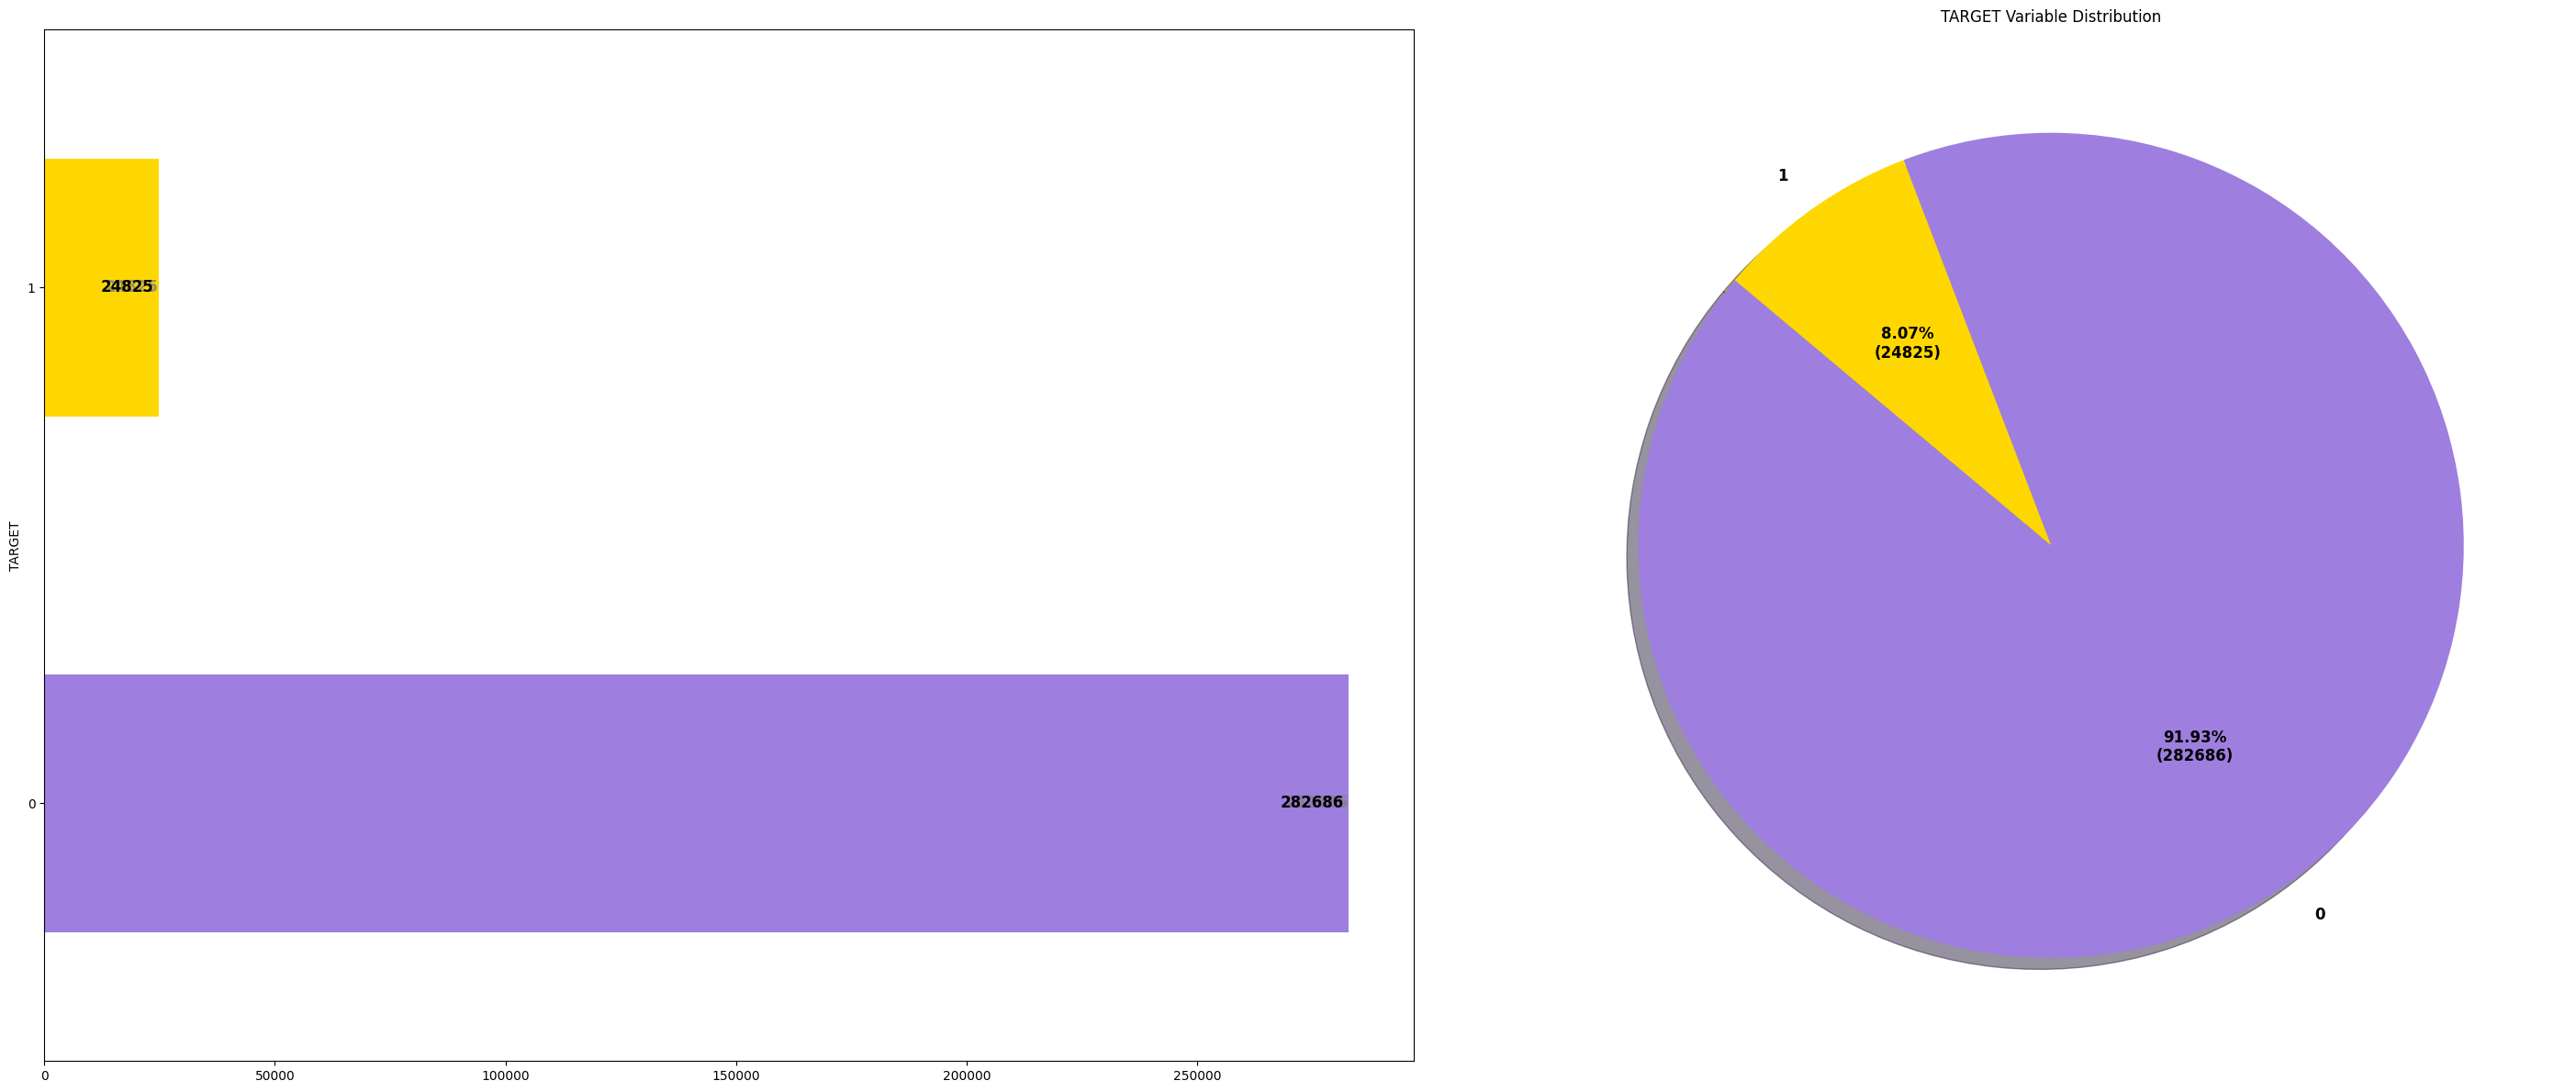

In [22]:
from scripts.distributionchart import plot_value_counts
plot_value_counts(current_data, 'TARGET')



# clean data

In [23]:
import pandas as pd
from scripts.dataclean import preprocess_for_lightgbm
merged_data = preprocess_for_lightgbm(df2, 'SK_ID_CURR')
print(merged_data.dtypes)


Sample of the processed data saved to: /Users/danramirez/mbs-fraud-detection/02-output/testmerge.csv
TARGET                               int64
CNT_CHILDREN                         int64
AMT_INCOME_TOTAL                   float64
AMT_CREDIT                         float64
AMT_ANNUITY                        float64
                                    ...   
WALLSMATERIAL_MODE_Panel             int64
WALLSMATERIAL_MODE_Stone__brick      int64
WALLSMATERIAL_MODE_Wooden            int64
EMERGENCYSTATE_MODE_No               int64
EMERGENCYSTATE_MODE_Yes              int64
Length: 245, dtype: object


# Top Factors

In [24]:
from scripts.lgbmmodels import train_lightgbm_model
bst_model, model_accuracy,X_test = train_lightgbm_model(merged_data, 'TARGET')


[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11375
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 234
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.246886
Accuracy: 0.919711233598361


## LightGBM Model Training Summary

- **Imbalance in Target Variable:**
  - Number of positive instances: 19,876
  - Number of negative instances: 226,132
  

- **Model Training Details:**
  - Auto-choosing row-wise multi-threading was enabled with an overhead of 0.036940 seconds.
    - To remove this overhead, `force_row_wise=true` can be set.
    - If memory is an issue, `force_col_wise=true` can be used instead.
  - Total bins used for features: 11,375
  - Data points in the training set: 246,008
  - Number of features used: 234
  - Initial score for training started from: -2.431606 (based on the proportion of positive instances, pavg=0.080794).
  

- **Training Process:**
  - Training continued until the validation scores didn't improve for 10 rounds.
  - The best iteration reported a binary log loss of 0.246886 on the validation set.



- **Model Performance:**
  - The accuracy of the model on the test set is approximately 91.97%.



# Shap Values— Top Features

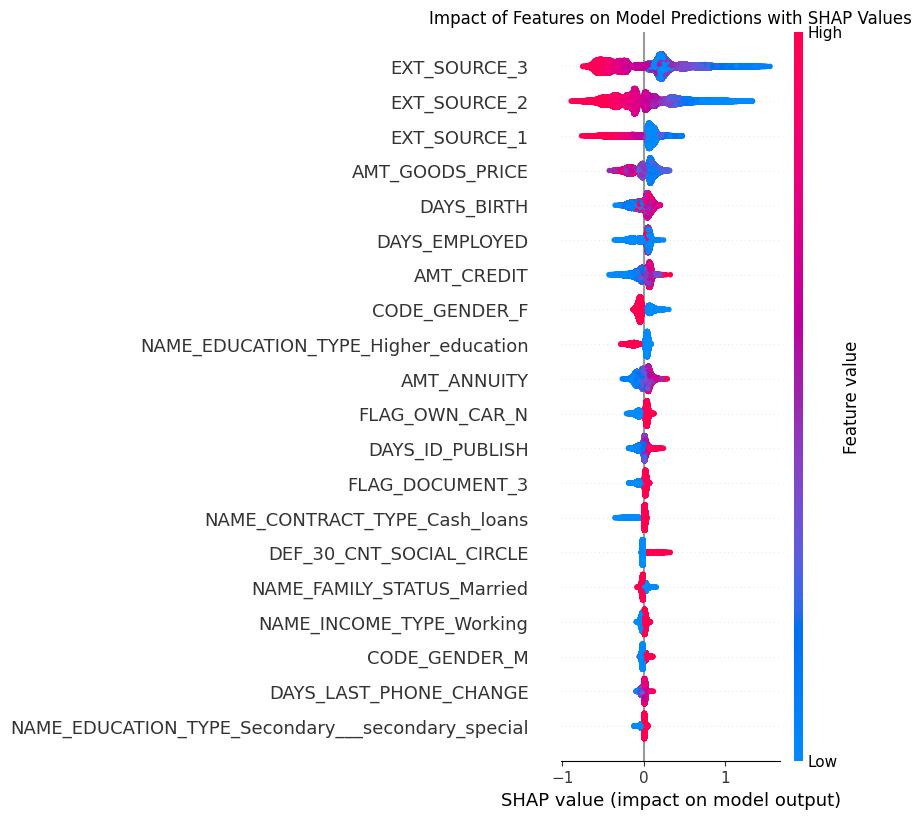

In [25]:
from scripts.lgbmmodels import generate_shap_summary_plot
generate_shap_summary_plot(bst_model, X_test)

## Overview

The SHAP summary plot illustrates the impact of various features on a predictive model's output, indicating how each feature contributes to the model's predictions.

## Key Features by Impact

- **EXT_SOURCE_3**: Shows the most considerable impact on model predictions, generally contributing to higher prediction values when the feature value is high.
- **EXT_SOURCE_2 and EXT_SOURCE_1**: Also significant, these features exhibit a mix of high and low SHAP values.

## Observations on Feature Impact

- Features like `AMT_GOODS_PRICE`, `DAYS_EMPLOYED`, and `DAYS_BIRTH` demonstrate varied impacts on model output, suggesting complex interactions.
- The color intensity of the points (pink for higher values and blue for lower values) reflects the feature's value, indicating its influence on the prediction.

## Summary of Insights

External source features notably influence prediction outcomes, with the model heavily weighing these attributes. The variability in SHAP values for features like `AMT_GOODS_PRICE`, `DAYS_EMPLOYED`, and `DAYS_BIRTH` suggests that their impact on the model's predictions changes across different observations.

## Conclusion

The SHAP summary plot highlights external source features as key drivers in the model's predictive capabilities, with personal client attributes also providing substantial influence. These insights are valuable for understanding the model's behavior, guiding feature engineering efforts, and potentially enhancing model performance.

### Plot Interpretation
- The color of the dots (from blue to red) corresponds to the feature value from low to high.
- The positioning of the dots on the x-axis indicates the SHAP value's impact on the model's output.
- Red dots positioned to the right suggest that higher feature values contribute to an increased likelihood of fraud.
- Blue dots to the left suggest that lower feature values contribute to an increased likelihood of fraud.
- The center area, where blue and red dots overlap, shows where feature values do not clearly distinguish between fraud and non-fraud cases.


# Distribution Charts by Target

Visualizing distributions for specified numeric columns: Index(['AMT_GOODS_PRICE', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype='object').


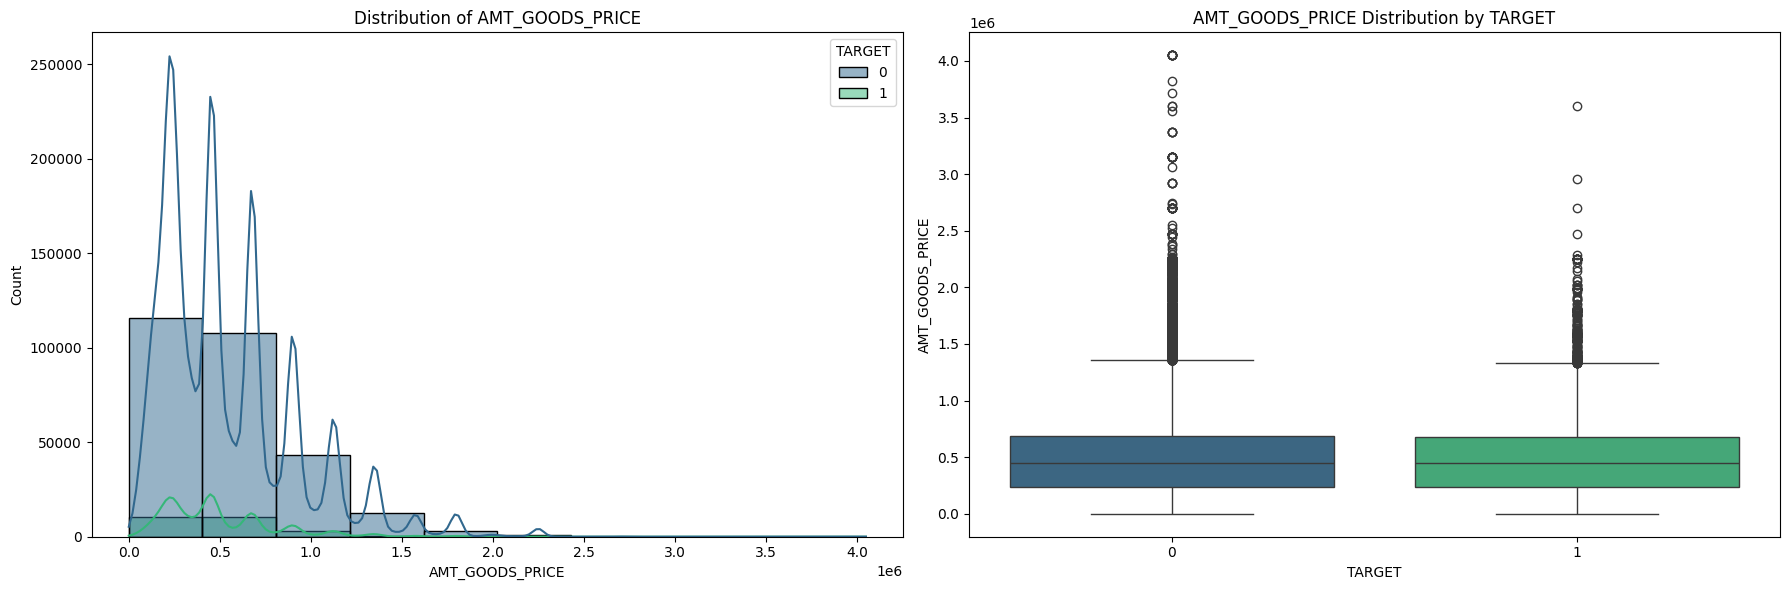

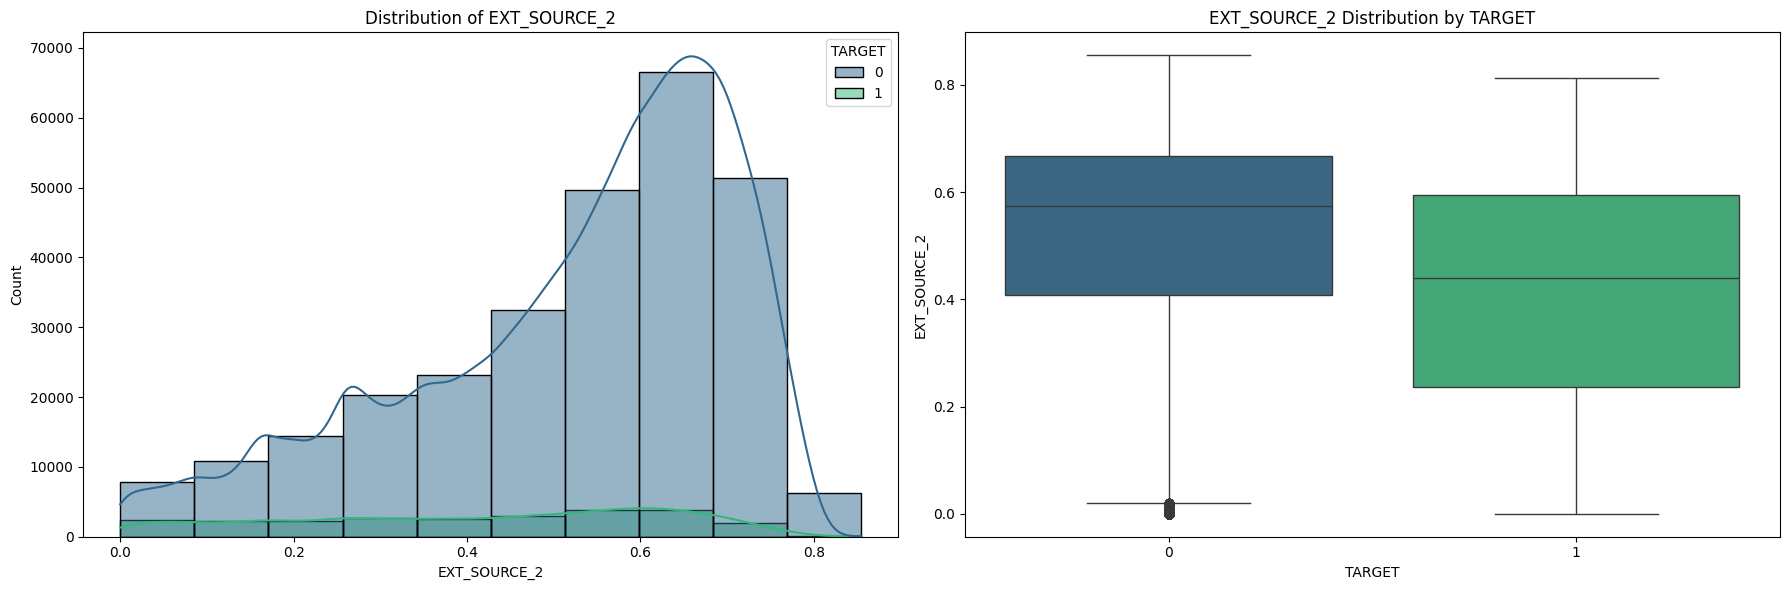

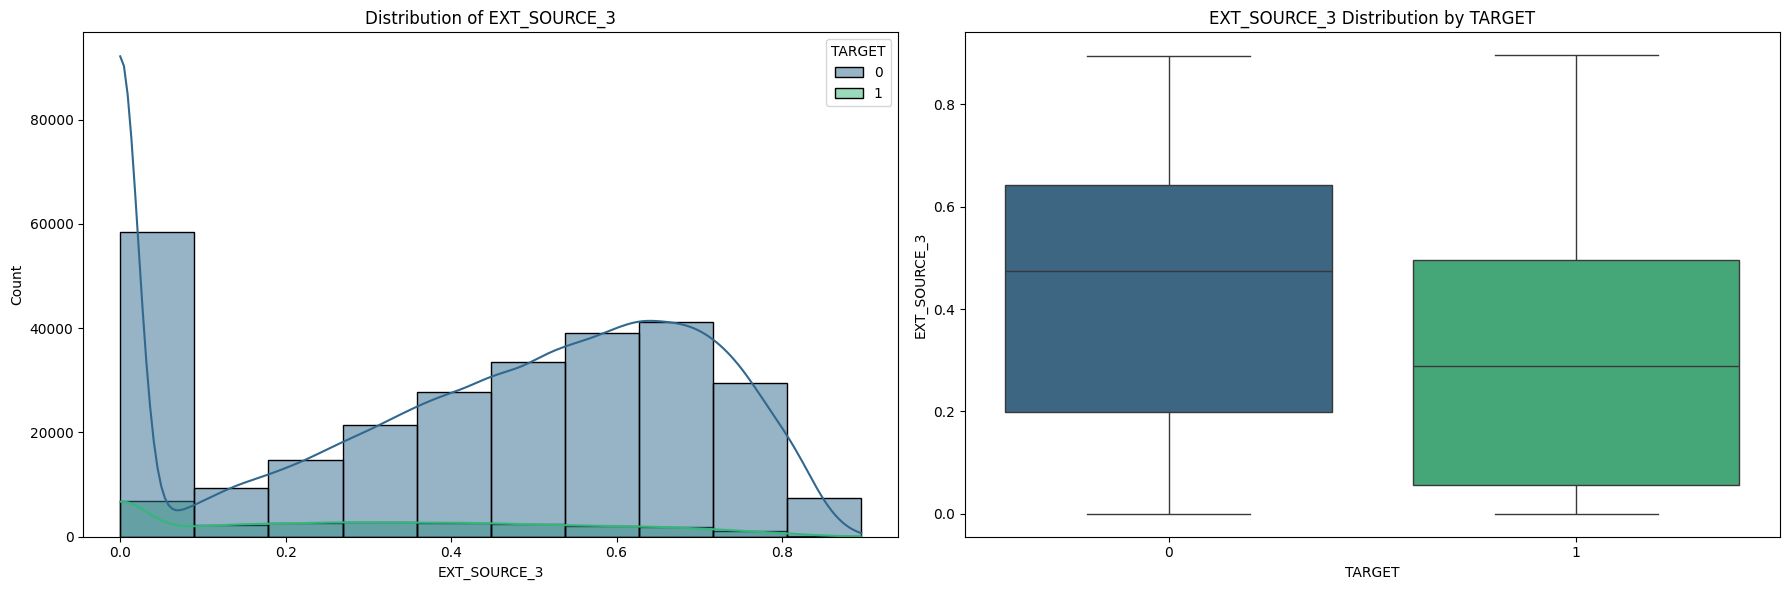

In [26]:
from scripts.distributionchart import distribution_graphs_objects,visualize_specific_distributions


features_list = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'AMT_GOODS_PRICE']
visualize_specific_distributions(merged_data, features_list, segmentation_column='TARGET', exclude_columns=[])